# VN Model Comparison Evaluation 📊🤖

**Purpose:** Comprehensive comparison of three VN dating simulator models:
1. **VN_emotion** - Merged character WITH emotion conditioning
2. **VN_no_emotion** - Merged character WITHOUT emotion conditioning
3. **VN_split** - 4 separate character models (Monika, Sayori, Natsuki, Yuri)

**Evaluation Approach:**
- ✅ Memory-efficient: Evaluate one model at a time
- ✅ Comprehensive metrics: Quality + Emotion + Character + Performance
- ✅ Visual comparisons: Charts, plots, and heatmaps
- ✅ Resumable: Results saved per model

**Metrics Evaluated:**
- Reference-Free: Perplexity, Distinct-1/2/3, Repetition Ratio, Response Length
- Emotion Appropriateness: Keyword matching, length appropriateness
- Character Consistency: Name bleeding, trait consistency
- Performance: Model size, inference speed, memory usage

---

## 1. Setup & Configuration ⚙️

In [1]:
# Install dependencies
!pip install -q torch transformers peft accelerate
!pip install -q matplotlib seaborn pandas numpy
!pip install -q tqdm scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Core imports
import torch
import json
import pandas as pd
import numpy as np
import re
import time
import gc
from pathlib import Path
from datetime import datetime
from tqdm.notebook import tqdm
from collections import defaultdict

# Transformers and PEFT
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from peft import PeftModel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful")

✓ All imports successful


In [3]:
# Add project root to path for imports
import sys
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import evaluation modules
from src.evaluation.emotion_metrics import EmotionAppropriatenessEvaluator
from src.evaluation.character_consistency import CharacterConsistencyEvaluator

print(f"✓ Project root: {project_root}")
print("✓ Evaluation modules imported")

✓ Project root: /common/home/projectgrps/CS425/CS425G3/CS425-Dating-Simulator
✓ Evaluation modules imported


In [4]:
# GPU Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("⚠️  No GPU detected - evaluation will be slow")

Device: cuda
GPU: NVIDIA GeForce RTX 3090
Memory: 25.31 GB
CUDA Version: 12.8


### Configuration

In [5]:
# ==================== CONFIGURATION ====================

# Model checkpoint paths (CUSTOMIZE THESE)
MODEL_CONFIGS = {
    'vn_emotion': {
        'name': 'VN Emotion (Merged)',
        'checkpoint_path': '../checkpoints/13_11_2025_dating_sim_vn__emotion',
        'type': 'merged',
        'has_emotion': True,
        'characters': ['Unified']  # Single merged character
    },
    'vn_no_emotion': {
        'name': 'VN No Emotion (Merged)',
        'checkpoint_path': '../checkpoints/13_11_2025_dating_sim_vn__no_emotion',
        'type': 'merged',
        'has_emotion': False,
        'characters': ['Unified']
    },
    'vn_split': {
        'name': 'VN Split (4 Characters)',
        'checkpoint_path': '../checkpoints/13_11_2025_dating_sim_vn__split',
        'type': 'split',
        'has_emotion': True,
        'characters': ['Monika', 'Sayori', 'Natsuki', 'Yuri']  # 4 separate characters
    }
}

# Base model
BASE_MODEL = "meta-llama/Llama-3.1-8B-Instruct"

# Results directory
RESULTS_DIR = Path('../results/vn_comparison')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Generation parameters
GEN_CONFIG = {
    'max_new_tokens': 50,
    'temperature': 0.7,
    'top_p': 0.85,
    'do_sample': True,
    'repetition_penalty': 1.2,
    'no_repeat_ngram_size': 3,
}

print("Configuration:")
print(f"  Models to evaluate: {len(MODEL_CONFIGS)}")
for model_id, config in MODEL_CONFIGS.items():
    print(f"    - {config['name']}: {config['checkpoint_path']}")
print(f"  Results directory: {RESULTS_DIR}")
print(f"  Generation config: {GEN_CONFIG}")

Configuration:
  Models to evaluate: 3
    - VN Emotion (Merged): ../checkpoints/13_11_2025_dating_sim_vn__emotion
    - VN No Emotion (Merged): ../checkpoints/13_11_2025_dating_sim_vn__no_emotion
    - VN Split (4 Characters): ../checkpoints/13_11_2025_dating_sim_vn__split
  Results directory: ../results/vn_comparison
  Generation config: {'max_new_tokens': 50, 'temperature': 0.7, 'top_p': 0.85, 'do_sample': True, 'repetition_penalty': 1.2, 'no_repeat_ngram_size': 3}


---
## 2. Custom Test Dataset Creation 📝

Create ~60-80 test prompts covering different characters, emotions, and affection levels.

In [6]:
# Test prompt templates
TEST_PROMPTS = [
    # ===== GREETINGS & CASUAL (15 prompts) =====
    {
        "character": "Monika",
        "emotion": "joy",
        "affection": 40,
        "user_input": "Hi Monika! How are you doing today?",
        "scenario": "greeting"
    },
    {
        "character": "Sayori",
        "emotion": "joy",
        "affection": 50,
        "user_input": "Good morning! You seem really happy today!",
        "scenario": "greeting"
    },
    {
        "character": "Natsuki",
        "emotion": "neutral",
        "affection": 25,
        "user_input": "Hey, what are you up to?",
        "scenario": "greeting"
    },
    {
        "character": "Yuri",
        "emotion": "neutral",
        "affection": 30,
        "user_input": "Hello Yuri. Mind if I join you?",
        "scenario": "greeting"
    },
    {
        "character": "Monika",
        "emotion": "neutral",
        "affection": 60,
        "user_input": "How's the Literature Club going?",
        "scenario": "casual"
    },
    {
        "character": "Sayori",
        "emotion": "neutral",
        "affection": 45,
        "user_input": "What are you working on?",
        "scenario": "casual"
    },
    {
        "character": "Natsuki",
        "emotion": "joy",
        "affection": 40,
        "user_input": "Did you bake something today?",
        "scenario": "casual"
    },
    {
        "character": "Yuri",
        "emotion": "neutral",
        "affection": 35,
        "user_input": "What are you reading?",
        "scenario": "casual"
    },
    {
        "character": "Monika",
        "emotion": "joy",
        "affection": 55,
        "user_input": "I love spending time with you!",
        "scenario": "casual"
    },
    {
        "character": "Sayori",
        "emotion": "joy",
        "affection": 65,
        "user_input": "You always know how to cheer me up.",
        "scenario": "casual"
    },
    {
        "character": "Natsuki",
        "emotion": "neutral",
        "affection": 30,
        "user_input": "Can I try some of your cupcakes?",
        "scenario": "casual"
    },
    {
        "character": "Yuri",
        "emotion": "joy",
        "affection": 50,
        "user_input": "I'd love to discuss books with you more often.",
        "scenario": "casual"
    },
    {
        "character": "Monika",
        "emotion": "neutral",
        "affection": 70,
        "user_input": "Thanks for always being there for me.",
        "scenario": "casual"
    },
    {
        "character": "Sayori",
        "emotion": "neutral",
        "affection": 55,
        "user_input": "Want to walk home together?",
        "scenario": "casual"
    },
    {
        "character": "Natsuki",
        "emotion": "joy",
        "affection": 50,
        "user_input": "Your manga collection is impressive!",
        "scenario": "casual"
    },
    
    # ===== COMPLIMENTS & APPRECIATION (15 prompts) =====
    {
        "character": "Monika",
        "emotion": "joy",
        "affection": 65,
        "user_input": "I really enjoyed your poem today!",
        "scenario": "compliment"
    },
    {
        "character": "Sayori",
        "emotion": "joy",
        "affection": 60,
        "user_input": "Your smile always brightens my day.",
        "scenario": "compliment"
    },
    {
        "character": "Natsuki",
        "emotion": "joy",
        "affection": 45,
        "user_input": "These cupcakes are amazing! You're really talented.",
        "scenario": "compliment"
    },
    {
        "character": "Yuri",
        "emotion": "joy",
        "affection": 55,
        "user_input": "Your taste in literature is really impressive!",
        "scenario": "compliment"
    },
    {
        "character": "Monika",
        "emotion": "joy",
        "affection": 75,
        "user_input": "I appreciate how thoughtful you are.",
        "scenario": "compliment"
    },
    {
        "character": "Sayori",
        "emotion": "joy",
        "affection": 70,
        "user_input": "You're such a caring friend.",
        "scenario": "compliment"
    },
    {
        "character": "Natsuki",
        "emotion": "joy",
        "affection": 55,
        "user_input": "I love how passionate you are about things.",
        "scenario": "compliment"
    },
    {
        "character": "Yuri",
        "emotion": "joy",
        "affection": 65,
        "user_input": "I'd love to hear you read your poetry.",
        "scenario": "compliment"
    },
    {
        "character": "Monika",
        "emotion": "joy",
        "affection": 80,
        "user_input": "You're an amazing club president.",
        "scenario": "compliment"
    },
    {
        "character": "Sayori",
        "emotion": "joy",
        "affection": 75,
        "user_input": "I'm so glad we're friends.",
        "scenario": "compliment"
    },
    {
        "character": "Natsuki",
        "emotion": "joy",
        "affection": 60,
        "user_input": "You have great taste in manga.",
        "scenario": "compliment"
    },
    {
        "character": "Yuri",
        "emotion": "joy",
        "affection": 70,
        "user_input": "You're really elegant and thoughtful.",
        "scenario": "compliment"
    },
    {
        "character": "Monika",
        "emotion": "joy",
        "affection": 85,
        "user_input": "This conversation means a lot to me.",
        "scenario": "compliment"
    },
    {
        "character": "Sayori",
        "emotion": "joy",
        "affection": 80,
        "user_input": "Your energy is contagious in the best way.",
        "scenario": "compliment"
    },
    {
        "character": "Natsuki",
        "emotion": "joy",
        "affection": 65,
        "user_input": "You're pretty cool once people get to know you.",
        "scenario": "compliment"
    },
    
    # ===== QUESTIONS & CURIOSITY (15 prompts) =====
    {
        "character": "Monika",
        "emotion": "neutral",
        "affection": 50,
        "user_input": "What made you start the Literature Club?",
        "scenario": "question"
    },
    {
        "character": "Sayori",
        "emotion": "neutral",
        "affection": 40,
        "user_input": "What do you like to do in your free time?",
        "scenario": "question"
    },
    {
        "character": "Natsuki",
        "emotion": "neutral",
        "affection": 35,
        "user_input": "What's your favorite manga series?",
        "scenario": "question"
    },
    {
        "character": "Yuri",
        "emotion": "neutral",
        "affection": 40,
        "user_input": "Tell me about your favorite book.",
        "scenario": "question"
    },
    {
        "character": "Monika",
        "emotion": "neutral",
        "affection": 45,
        "user_input": "What are your hobbies?",
        "scenario": "question"
    },
    {
        "character": "Sayori",
        "emotion": "neutral",
        "affection": 50,
        "user_input": "What's your favorite thing about the club?",
        "scenario": "question"
    },
    {
        "character": "Natsuki",
        "emotion": "neutral",
        "affection": 40,
        "user_input": "How did you get into baking?",
        "scenario": "question"
    },
    {
        "character": "Yuri",
        "emotion": "neutral",
        "affection": 45,
        "user_input": "What draws you to psychological horror?",
        "scenario": "question"
    },
    {
        "character": "Monika",
        "emotion": "neutral",
        "affection": 55,
        "user_input": "What's your favorite poem?",
        "scenario": "question"
    },
    {
        "character": "Sayori",
        "emotion": "neutral",
        "affection": 55,
        "user_input": "What makes you happiest?",
        "scenario": "question"
    },
    {
        "character": "Natsuki",
        "emotion": "neutral",
        "affection": 45,
        "user_input": "What's your favorite thing to bake?",
        "scenario": "question"
    },
    {
        "character": "Yuri",
        "emotion": "neutral",
        "affection": 50,
        "user_input": "What authors do you admire most?",
        "scenario": "question"
    },
    {
        "character": "Monika",
        "emotion": "neutral",
        "affection": 65,
        "user_input": "What do you value most in a friendship?",
        "scenario": "question"
    },
    {
        "character": "Sayori",
        "emotion": "neutral",
        "affection": 60,
        "user_input": "What's your ideal way to spend a day?",
        "scenario": "question"
    },
    {
        "character": "Natsuki",
        "emotion": "neutral",
        "affection": 50,
        "user_input": "What do you think makes a good story?",
        "scenario": "question"
    },
    
    # ===== EMOTIONAL SUPPORT & DEEPER CONVERSATIONS (15 prompts) =====
    {
        "character": "Monika",
        "emotion": "sadness",
        "affection": 60,
        "user_input": "I'm feeling a bit down today...",
        "scenario": "support"
    },
    {
        "character": "Sayori",
        "emotion": "sadness",
        "affection": 65,
        "user_input": "Is everything okay? You seem a bit off...",
        "scenario": "support"
    },
    {
        "character": "Natsuki",
        "emotion": "anger",
        "affection": 40,
        "user_input": "I'm just frustrated with everything right now.",
        "scenario": "support"
    },
    {
        "character": "Yuri",
        "emotion": "sadness",
        "affection": 55,
        "user_input": "I've been feeling anxious lately...",
        "scenario": "support"
    },
    {
        "character": "Monika",
        "emotion": "neutral",
        "affection": 70,
        "user_input": "Do you ever feel overwhelmed by everything?",
        "scenario": "deep"
    },
    {
        "character": "Sayori",
        "emotion": "sadness",
        "affection": 70,
        "user_input": "It's okay to not always be cheerful, you know.",
        "scenario": "support"
    },
    {
        "character": "Natsuki",
        "emotion": "neutral",
        "affection": 55,
        "user_input": "You don't have to act tough around me.",
        "scenario": "deep"
    },
    {
        "character": "Yuri",
        "emotion": "neutral",
        "affection": 65,
        "user_input": "I really value our conversations.",
        "scenario": "deep"
    },
    {
        "character": "Monika",
        "emotion": "joy",
        "affection": 85,
        "user_input": "Would you like to go out for lunch?",
        "scenario": "deep"
    },
    {
        "character": "Sayori",
        "emotion": "joy",
        "affection": 85,
        "user_input": "You mean a lot to me.",
        "scenario": "deep"
    },
    {
        "character": "Natsuki",
        "emotion": "neutral",
        "affection": 65,
        "user_input": "I'm glad we've gotten closer.",
        "scenario": "deep"
    },
    {
        "character": "Yuri",
        "emotion": "joy",
        "affection": 75,
        "user_input": "I feel like I can be myself around you.",
        "scenario": "deep"
    },
    {
        "character": "Monika",
        "emotion": "neutral",
        "affection": 90,
        "user_input": "What does the future hold for us?",
        "scenario": "deep"
    },
    {
        "character": "Sayori",
        "emotion": "joy",
        "affection": 90,
        "user_input": "You've made such a difference in my life.",
        "scenario": "deep"
    },
    {
        "character": "Yuri",
        "emotion": "joy",
        "affection": 85,
        "user_input": "I cherish every moment we spend together.",
        "scenario": "deep"
    },
    
    # ===== EDGE CASES & MIXED SCENARIOS (10 prompts) =====
    {
        "character": "Monika",
        "emotion": "surprise",
        "affection": 50,
        "user_input": "I wrote a poem! Want to read it?",
        "scenario": "surprise"
    },
    {
        "character": "Sayori",
        "emotion": "surprise",
        "affection": 60,
        "user_input": "I brought cookies for everyone!",
        "scenario": "surprise"
    },
    {
        "character": "Natsuki",
        "emotion": "surprise",
        "affection": 45,
        "user_input": "I actually really like manga too.",
        "scenario": "surprise"
    },
    {
        "character": "Yuri",
        "emotion": "surprise",
        "affection": 50,
        "user_input": "I started reading Portrait of Markov because of you!",
        "scenario": "surprise"
    },
    {
        "character": "Monika",
        "emotion": "anger",
        "affection": 35,
        "user_input": "Sorry, I can't make it to the club today.",
        "scenario": "disappointment"
    },
    {
        "character": "Sayori",
        "emotion": "sadness",
        "affection": 50,
        "user_input": "I might be late to our meeting...",
        "scenario": "disappointment"
    },
    {
        "character": "Natsuki",
        "emotion": "anger",
        "affection": 30,
        "user_input": "Manga is just for kids, right?",
        "scenario": "confrontation"
    },
    {
        "character": "Yuri",
        "emotion": "sadness",
        "affection": 40,
        "user_input": "I don't really understand poetry...",
        "scenario": "disappointment"
    },
    {
        "character": "Monika",
        "emotion": "neutral",
        "affection": 20,
        "user_input": "Tell me about the Literature Club.",
        "scenario": "introduction"
    },
    {
        "character": "Natsuki",
        "emotion": "neutral",
        "affection": 15,
        "user_input": "So you're part of the Literature Club?",
        "scenario": "introduction"
    },
]

print(f"✓ Created {len(TEST_PROMPTS)} test prompts")
print(f"  Characters: {len(set(p['character'] for p in TEST_PROMPTS))}")
print(f"  Emotions: {len(set(p['emotion'] for p in TEST_PROMPTS))}")
print(f"  Scenarios: {len(set(p['scenario'] for p in TEST_PROMPTS))}")

# Statistics
char_counts = pd.Series([p['character'] for p in TEST_PROMPTS]).value_counts()
emotion_counts = pd.Series([p['emotion'] for p in TEST_PROMPTS]).value_counts()

print("\nCharacter distribution:")
for char, count in char_counts.items():
    print(f"  {char}: {count}")

print("\nEmotion distribution:")
for emotion, count in emotion_counts.items():
    print(f"  {emotion}: {count}")

✓ Created 70 test prompts
  Characters: 4
  Emotions: 5
  Scenarios: 10

Character distribution:
  Monika: 19
  Sayori: 18
  Natsuki: 18
  Yuri: 15

Emotion distribution:
  neutral: 30
  joy: 27
  sadness: 6
  surprise: 4
  anger: 3


In [7]:
# Save test prompts
test_prompts_path = RESULTS_DIR / 'test_prompts.json'
with open(test_prompts_path, 'w', encoding='utf-8') as f:
    json.dump(TEST_PROMPTS, f, indent=2, ensure_ascii=False)

print(f"✓ Saved test prompts to: {test_prompts_path}")

✓ Saved test prompts to: ../results/vn_comparison/test_prompts.json


---
## 3. Model Evaluation Loop (Memory-Efficient) 🔄

Evaluate each model one at a time, saving results to disk.

### Helper Functions

In [8]:
# Character personas for generation
VN_CHARACTER_DESCRIPTIONS = {
    "Monika": "You are Monika, the Literature Club president. Confident, intelligent, and caring. You're thoughtful and philosophical, ambitious and kind with a mysterious side.",
    "Sayori": "You are Sayori, a cheerful childhood friend. Bubbly, energetic, and optimistic, though you hide deeper feelings. Sunny personality, slightly clumsy, deeply caring.",
    "Natsuki": "You are Natsuki, a tsundere who loves manga and baking. Defensive exterior but sweet underneath. Feisty, proud, and secretly soft-hearted.",
    "Yuri": "You are Yuri, shy and sophisticated with a passion for literature. Elegant but socially anxious. Intellectual, timid, and intense when comfortable.",
    "Unified": """You are a member of the Literature Club - friendly, thoughtful, and passionate about literature and writing.

You have a nuanced personality that adapts to the situation and your mood. You can be:
- Confident and philosophical when discussing ideas
- Warm and caring when someone needs support
- Direct and passionate about your interests
- Shy and introspective in new situations

You value meaningful connections, enjoy deep conversations, and appreciate both classic literature and creative expression. You're genuine in your emotions and thoughtful in your responses."""
}

def get_emotion_guidance(emotion: str) -> str:
    """Get response guidance based on user emotion"""
    guidance = {
        'joy': "The user is happy! Match their enthusiasm and share in their joy.",
        'sadness': "The user seems down. Be supportive and caring.",
        'anger': "The user appears upset. Stay calm, be understanding, and don't escalate.",
        'fear': "The user seems worried. Be reassuring and supportive.",
        'surprise': "Respond naturally based on the conversation context.",
        'neutral': "Respond naturally based on the conversation context.",
    }
    return guidance.get(emotion, "Respond naturally based on the conversation context.")

def build_system_prompt(character: str, emotion: str, affection: int, has_emotion: bool) -> str:
    """Build system prompt for generation"""
    char_desc = VN_CHARACTER_DESCRIPTIONS.get(character, VN_CHARACTER_DESCRIPTIONS['Unified'])
    
    if has_emotion:
        emotion_guidance = get_emotion_guidance(emotion)
        return f"""{char_desc}

Current affection: {affection}/100
User's emotional state: {emotion}

{emotion_guidance}"""
    else:
        return f"""{char_desc}

Current affection: {affection}/100"""

def generate_response(model, tokenizer, prompt_data: dict, has_emotion: bool) -> tuple:
    """Generate response and measure time"""
    character = prompt_data['character'] if prompt_data['character'] in VN_CHARACTER_DESCRIPTIONS else 'Unified'
    user_input = prompt_data['user_input']
    emotion = prompt_data['emotion']
    affection = prompt_data['affection']
    
    # Build messages
    system_content = build_system_prompt(character, emotion, affection, has_emotion)
    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": user_input}
    ]
    
    # Apply chat template
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    input_length = inputs['input_ids'].shape[1]
    
    # Generate with timing
    start_time = time.time()
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            **GEN_CONFIG,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    inference_time = time.time() - start_time
    
    # Decode
    generated_tokens = outputs[0][input_length:]
    response = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
    
    # Clean
    response = re.sub(r'<[^>]+>\s*', '', response)
    response = ' '.join(response.split())
    
    return response, inference_time, len(generated_tokens)

print("✓ Helper functions defined")

✓ Helper functions defined


### Reference-Free Metrics Calculator

In [9]:
def calculate_distinct_n(responses: list, n: int) -> float:
    """Calculate Distinct-n (lexical diversity)"""
    all_ngrams = []
    for response in responses:
        tokens = response.lower().split()
        ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        all_ngrams.extend(ngrams)
    
    if not all_ngrams:
        return 0.0
    
    return len(set(all_ngrams)) / len(all_ngrams)

def calculate_repetition_ratio(response: str) -> float:
    """Calculate self-repetition ratio"""
    tokens = response.lower().split()
    if len(tokens) < 2:
        return 0.0
    
    bigrams = [tuple(tokens[i:i+2]) for i in range(len(tokens)-1)]
    if not bigrams:
        return 0.0
    
    unique_bigrams = len(set(bigrams))
    total_bigrams = len(bigrams)
    
    return 1 - (unique_bigrams / total_bigrams)

def calculate_perplexity(model, tokenizer, responses: list) -> list:
    """Calculate perplexity for each response"""
    perplexities = []
    
    for response in tqdm(responses, desc="Calculating perplexity", leave=False):
        inputs = tokenizer(response, return_tensors='pt', truncation=True, max_length=512).to(model.device)
        
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs['input_ids'])
            loss = outputs.loss.item()
            perplexity = np.exp(loss)
            perplexities.append(perplexity)
    
    return perplexities

def calculate_reference_free_metrics(model, tokenizer, generations: list) -> dict:
    """Calculate all reference-free metrics"""
    responses = [g['response'] for g in generations]
    
    # Diversity metrics
    distinct_1 = calculate_distinct_n(responses, 1)
    distinct_2 = calculate_distinct_n(responses, 2)
    distinct_3 = calculate_distinct_n(responses, 3)
    
    # Repetition
    repetitions = [calculate_repetition_ratio(r) for r in responses]
    mean_repetition = np.mean(repetitions)
    
    # Length
    lengths = [len(r.split()) for r in responses]
    
    # Perplexity
    perplexities = calculate_perplexity(model, tokenizer, responses)
    
    return {
        'distinct_1': distinct_1,
        'distinct_2': distinct_2,
        'distinct_3': distinct_3,
        'mean_repetition': mean_repetition,
        'repetition_per_sample': repetitions,
        'mean_length': np.mean(lengths),
        'std_length': np.std(lengths),
        'min_length': np.min(lengths),
        'max_length': np.max(lengths),
        'mean_perplexity': np.mean(perplexities),
        'std_perplexity': np.std(perplexities),
        'perplexities': perplexities
    }

print("✓ Reference-free metrics calculator defined")

✓ Reference-free metrics calculator defined


### Model Size & Performance Measurement

In [10]:
def get_model_size_info(model_path: Path) -> dict:
    """Get model size information"""
    size_info = {}
    
    # Disk size
    total_size = 0
    if model_path.exists():
        for file in model_path.rglob('*'):
            if file.is_file():
                total_size += file.stat().st_size
    
    size_info['disk_size_mb'] = total_size / (1024 * 1024)
    size_info['disk_size_gb'] = total_size / (1024 * 1024 * 1024)
    
    return size_info

def get_model_param_count(model) -> dict:
    """Get model parameter count"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    return {
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'trainable_percent': (trainable_params / total_params * 100) if total_params > 0 else 0
    }

def measure_memory_usage() -> dict:
    """Measure current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 * 1024 * 1024)  # GB
        reserved = torch.cuda.memory_reserved() / (1024 * 1024 * 1024)  # GB
        return {
            'gpu_memory_allocated_gb': allocated,
            'gpu_memory_reserved_gb': reserved
        }
    return {}

print("✓ Model size & performance measurement functions defined")

✓ Model size & performance measurement functions defined


### Main Evaluation Function

In [11]:
def convert_numpy_types(obj):
    """Recursively convert numpy types to native Python types for JSON serialization."""
    import numpy as np
    
    if isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

def evaluate_model(model_id: str, config: dict, test_prompts: list, force_rerun: bool = False):
    """
    Evaluate a single model and save results.
    
    Args:
        model_id: Model identifier (e.g., 'vn_emotion')
        config: Model configuration dict
        test_prompts: List of test prompts
        force_rerun: If True, re-evaluate even if results exist
    """
    print("="*80)
    print(f"Evaluating: {config['name']}")
    print("="*80)
    
    # Check if results already exist
    results_path = RESULTS_DIR / f"{model_id}_metrics.json"
    generations_path = RESULTS_DIR / f"{model_id}_generations.json"
    
    if results_path.exists() and not force_rerun:
        print(f"✓ Results already exist at {results_path}")
        print("  Set force_rerun=True to re-evaluate")
        return
    
    # Load model
    print(f"\n1. Loading model from {config['checkpoint_path']}...")
    checkpoint_path = Path(f"{config['checkpoint_path']}/final")
    
    if not checkpoint_path.exists():
        print(f"❌ Checkpoint not found: {checkpoint_path}")
        print("   Skipping this model...")
        return
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id
    
    # Load model (with LoRA adapter)
    base_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL,
        torch_dtype=torch.float16,
        device_map='auto',
        trust_remote_code=True
    )
    model = PeftModel.from_pretrained(base_model, checkpoint_path)
    model.eval()
    
    print("✓ Model loaded")
    
    # Get model info
    print("\n2. Collecting model information...")
    size_info = get_model_size_info(checkpoint_path)
    param_info = get_model_param_count(model)
    memory_info = measure_memory_usage()
    
    print(f"  Disk size: {size_info['disk_size_gb']:.2f} GB")
    print(f"  Total parameters: {param_info['total_parameters']:,}")
    print(f"  Trainable parameters: {param_info['trainable_parameters']:,} ({param_info['trainable_percent']:.2f}%)")
    if memory_info:
        print(f"  GPU memory: {memory_info['gpu_memory_allocated_gb']:.2f} GB allocated")
    
    # Generate responses
    print(f"\n3. Generating responses for {len(test_prompts)} prompts...")
    generations = []
    inference_times = []
    token_counts = []
    
    for prompt_data in tqdm(test_prompts, desc="Generating"):
        response, inf_time, num_tokens = generate_response(
            model, tokenizer, prompt_data, config['has_emotion']
        )
        
        generations.append({
            'character': prompt_data['character'],
            'emotion': prompt_data['emotion'],
            'affection': prompt_data['affection'],
            'scenario': prompt_data['scenario'],
            'user_input': prompt_data['user_input'],
            'response': response,
            'inference_time': inf_time,
            'num_tokens': num_tokens
        })
        
        inference_times.append(inf_time)
        token_counts.append(num_tokens)
    
    print("✓ Generation complete")
    
    # Save generations
    with open(generations_path, 'w', encoding='utf-8') as f:
        json.dump(generations, f, indent=2, ensure_ascii=False)
    print(f"✓ Saved generations to {generations_path}")
    
    # Calculate metrics
    print("\n4. Calculating metrics...")
    
    # Reference-free metrics
    print("  - Reference-free metrics...")
    ref_free_metrics = calculate_reference_free_metrics(model, tokenizer, generations)
    
    # Inference performance
    print("  - Inference performance...")
    performance_metrics = {
        'mean_inference_time': np.mean(inference_times),
        'median_inference_time': np.median(inference_times),
        'std_inference_time': np.std(inference_times),
        'mean_tokens_per_second': np.mean([tc / it if it > 0 else 0 for tc, it in zip(token_counts, inference_times)]),
        'total_generation_time': sum(inference_times)
    }
    
    # Emotion appropriateness (if has emotion)
    emotion_metrics = {}
    if config['has_emotion']:
        print("  - Emotion appropriateness...")
        emotion_evaluator = EmotionAppropriatenessEvaluator()
        
        # Evaluate each generation
        emotion_results = []
        for gen in generations:
            result = emotion_evaluator.evaluate_response(
                user_emotion=gen['emotion'],
                response=gen['response']
            )
            emotion_results.append(result)
        
        # Aggregate
        emotion_metrics = {
            'overall_appropriateness': np.mean([r['overall_appropriateness_score'] for r in emotion_results]),
            'keyword_score': np.mean([r['keyword_score'] for r in emotion_results]),
            'length_score': np.mean([r['length_score'] for r in emotion_results]),
            'per_emotion': {}
        }
        
        # Per-emotion breakdown
        for emotion in set(g['emotion'] for g in generations):
            emotion_gen_results = [r for g, r in zip(generations, emotion_results) if g['emotion'] == emotion]
            emotion_metrics['per_emotion'][emotion] = {
                'count': len(emotion_gen_results),
                'appropriateness': np.mean([r['overall_appropriateness_score'] for r in emotion_gen_results]),
                'keyword_score': np.mean([r['keyword_score'] for r in emotion_gen_results]),
                'length_score': np.mean([r['length_score'] for r in emotion_gen_results])
            }
    
    # Character consistency (if split model)
    character_metrics = {}
    if config['type'] == 'split':
        print("  - Character consistency...")
        character_evaluator = CharacterConsistencyEvaluator(
            character_names=['Monika', 'Sayori', 'Natsuki', 'Yuri']
        )
        
        # Evaluate each generation
        char_results = []
        for gen in generations:
            result = character_evaluator.evaluate_response(
                character=gen['character'],
                response=gen['response']
            )
            char_results.append(result)
        
        # Aggregate
        character_metrics = {
            'overall_consistency': np.mean([r['trait_score'] for r in char_results]),
            'name_bleeding_rate': np.mean([r['has_name_bleeding'] for r in char_results]),
            'per_character': {}
        }
        
        # Per-character breakdown
        for character in set(g['character'] for g in generations):
            char_gen_results = [r for g, r in zip(generations, char_results) if g['character'] == character]
            character_metrics['per_character'][character] = {
                'count': len(char_gen_results),
                'consistency': np.mean([r['trait_score'] for r in char_gen_results]),
                'name_bleeding': np.mean([r['has_name_bleeding'] for r in char_gen_results])
            }
    
    print("✓ Metrics calculated")
    
    # Compile all results
    results = {
        'model_id': model_id,
        'model_name': config['name'],
        'model_type': config['type'],
        'has_emotion': config['has_emotion'],
        'checkpoint_path': str(config['checkpoint_path']),
        'evaluation_timestamp': datetime.now().isoformat(),
        'num_test_prompts': len(test_prompts),
        'model_info': {
            **size_info,
            **param_info,
            **memory_info
        },
        'reference_free_metrics': ref_free_metrics,
        'performance_metrics': performance_metrics,
        'emotion_metrics': emotion_metrics,
        'character_metrics': character_metrics,
    }
    
    # Convert numpy types to Python native types for JSON serialization
    results = convert_numpy_types(results)
    
    # Save results
    with open(results_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    
    print(f"\n✓ Saved results to {results_path}")
    
    # Clean up
    print("\n5. Cleaning up memory...")
    del model
    del base_model
    del tokenizer
    gc.collect()
    torch.cuda.empty_cache()
    print("✓ Memory cleaned")
    
    print("\n" + "="*80)
    print(f"✅ Evaluation complete for {config['name']}")
    print("="*80 + "\n")

print("✓ Main evaluation function defined")

✓ Main evaluation function defined


### Run Evaluations

In [12]:
# Evaluate all models
# Set force_rerun=True to re-evaluate models even if results exist

for model_id, config in MODEL_CONFIGS.items():
    evaluate_model(model_id, config, TEST_PROMPTS, force_rerun=False)

Evaluating: VN Emotion (Merged)

1. Loading model from ../checkpoints/13_11_2025_dating_sim_vn__emotion...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Model loaded

2. Collecting model information...
  Disk size: 0.04 GB
  Total parameters: 8,037,076,992
  Trainable parameters: 0 (0.00%)
  GPU memory: 14.98 GB allocated

3. Generating responses for 70 prompts...


Generating:   0%|          | 0/70 [00:00<?, ?it/s]

✓ Generation complete
✓ Saved generations to ../results/vn_comparison/vn_emotion_generations.json

4. Calculating metrics...
  - Reference-free metrics...


Calculating perplexity:   0%|          | 0/70 [00:00<?, ?it/s]

  - Inference performance...
  - Emotion appropriateness...
✓ Metrics calculated

✓ Saved results to ../results/vn_comparison/vn_emotion_metrics.json

5. Cleaning up memory...
✓ Memory cleaned

✅ Evaluation complete for VN Emotion (Merged)

Evaluating: VN No Emotion (Merged)

1. Loading model from ../checkpoints/13_11_2025_dating_sim_vn__no_emotion...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Model loaded

2. Collecting model information...
  Disk size: 0.04 GB
  Total parameters: 8,037,076,992
  Trainable parameters: 0 (0.00%)
  GPU memory: 14.99 GB allocated

3. Generating responses for 70 prompts...


Generating:   0%|          | 0/70 [00:00<?, ?it/s]

✓ Generation complete
✓ Saved generations to ../results/vn_comparison/vn_no_emotion_generations.json

4. Calculating metrics...
  - Reference-free metrics...


Calculating perplexity:   0%|          | 0/70 [00:00<?, ?it/s]

  - Inference performance...
✓ Metrics calculated

✓ Saved results to ../results/vn_comparison/vn_no_emotion_metrics.json

5. Cleaning up memory...
✓ Memory cleaned

✅ Evaluation complete for VN No Emotion (Merged)

Evaluating: VN Split (4 Characters)

1. Loading model from ../checkpoints/13_11_2025_dating_sim_vn__split...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Model loaded

2. Collecting model information...
  Disk size: 0.04 GB
  Total parameters: 8,037,076,992
  Trainable parameters: 0 (0.00%)
  GPU memory: 14.99 GB allocated

3. Generating responses for 70 prompts...


Generating:   0%|          | 0/70 [00:00<?, ?it/s]

✓ Generation complete
✓ Saved generations to ../results/vn_comparison/vn_split_generations.json

4. Calculating metrics...
  - Reference-free metrics...


Calculating perplexity:   0%|          | 0/70 [00:00<?, ?it/s]

  - Inference performance...
  - Emotion appropriateness...
  - Character consistency...
✓ Metrics calculated

✓ Saved results to ../results/vn_comparison/vn_split_metrics.json

5. Cleaning up memory...
✓ Memory cleaned

✅ Evaluation complete for VN Split (4 Characters)



---
## 4. Comparative Analysis 📊

Load all results and compare across models.

### Load All Results

In [13]:
# Load results from all models
all_results = {}

for model_id in MODEL_CONFIGS.keys():
    results_path = RESULTS_DIR / f"{model_id}_metrics.json"
    if results_path.exists():
        with open(results_path, 'r', encoding='utf-8') as f:
            all_results[model_id] = json.load(f)
        print(f"✓ Loaded results for {model_id}")
    else:
        print(f"⚠️  Results not found for {model_id}")

if not all_results:
    print("\n❌ No results found. Please run the evaluation first.")
else:
    print(f"\n✓ Loaded results for {len(all_results)} models")

✓ Loaded results for vn_emotion
✓ Loaded results for vn_no_emotion
✓ Loaded results for vn_split

✓ Loaded results for 3 models


### Create Comparison Tables

In [14]:
# Overall metrics comparison
comparison_data = []

for model_id, results in all_results.items():
    ref_free = results['reference_free_metrics']
    perf = results['performance_metrics']
    model_info = results['model_info']
    
    row = {
        'Model': results['model_name'],
        'Type': results['model_type'],
        'Has Emotion': results['has_emotion'],
        'Size (GB)': model_info.get('disk_size_gb', 0),
        'Trainable %': model_info.get('trainable_percent', 0),
        'Distinct-1': ref_free['distinct_1'],
        'Distinct-2': ref_free['distinct_2'],
        'Distinct-3': ref_free['distinct_3'],
        'Repetition': ref_free['mean_repetition'],
        'Perplexity': ref_free['mean_perplexity'],
        'Mean Length': ref_free['mean_length'],
        'Inference Time (s)': perf['mean_inference_time'],
        'Tokens/sec': perf['mean_tokens_per_second'],
    }
    
    # Add emotion metrics if available
    if results['emotion_metrics']:
        row['Emotion Appropriateness'] = results['emotion_metrics']['overall_appropriateness']
    
    # Add character metrics if available
    if results['character_metrics']:
        row['Character Consistency'] = results['character_metrics']['overall_consistency']
        row['Name Bleeding Rate'] = results['character_metrics']['name_bleeding_rate']
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\n" + "="*80)
print("OVERALL MODEL COMPARISON")
print("="*80)
display(comparison_df)


OVERALL MODEL COMPARISON


,Model,Type,Has Emotion,Size (GB),Trainable %,Distinct-1,Distinct-2,Distinct-3,Repetition,Perplexity,Mean Length,Inference Time (s),Tokens/sec,Emotion Appropriateness,Character Consistency,Name Bleeding Rate
0,VN Emotion (Merged),merged,True,0.0415,0.0,0.3208,0.7981,0.9297,0.0011,14.9859,39.4143,2.4211,20.4012,0.2806,NaN,NaN
1,VN No Emotion (Merged),merged,False,0.0415,0.0,0.3385,0.7932,0.9258,0.0004,23.9867,38.5714,2.4248,20.4206,NaN,NaN,NaN
2,VN Split (4 Characters),split,True,0.0415,0.0,0.2841,0.7906,0.9537,0.0015,22.8996,38.1143,2.4672,20.2722,0.2835,0.0229,0.0


In [15]:
# Per-emotion comparison (if emotion models exist)
emotion_models = {k: v for k, v in all_results.items() if v['emotion_metrics']}

if emotion_models:
    print("\n" + "="*80)
    print("PER-EMOTION PERFORMANCE COMPARISON")
    print("="*80)
    
    # Get all emotions
    all_emotions = set()
    for results in emotion_models.values():
        all_emotions.update(results['emotion_metrics']['per_emotion'].keys())
    
    # Create comparison for each emotion
    emotion_comparison = []
    for emotion in sorted(all_emotions):
        row = {'Emotion': emotion}
        for model_id, results in emotion_models.items():
            if emotion in results['emotion_metrics']['per_emotion']:
                score = results['emotion_metrics']['per_emotion'][emotion]['appropriateness']
                row[results['model_name']] = score
        emotion_comparison.append(row)
    
    emotion_df = pd.DataFrame(emotion_comparison)
    emotion_df = emotion_df.round(4)
    display(emotion_df)


PER-EMOTION PERFORMANCE COMPARISON


,Emotion,VN Emotion (Merged),VN Split (4 Characters)
0,anger,0.3017,0.1657
1,joy,0.0829,0.0925
2,neutral,0.4267,0.4447
3,sadness,0.3209,0.2831
4,surprise,0.4425,0.4525


In [16]:
# Per-character comparison (if split model exists)
split_models = {k: v for k, v in all_results.items() if v['character_metrics']}

if split_models:
    print("\n" + "="*80)
    print("PER-CHARACTER PERFORMANCE COMPARISON")
    print("="*80)
    
    for model_id, results in split_models.items():
        print(f"\n{results['model_name']}:")
        
        char_data = []
        for character, metrics in results['character_metrics']['per_character'].items():
            char_data.append({
                'Character': character,
                'Count': metrics['count'],
                'Consistency': metrics['consistency'],
                'Name Bleeding': metrics['name_bleeding']
            })
        
        char_df = pd.DataFrame(char_data)
        char_df = char_df.round(4)
        display(char_df)


PER-CHARACTER PERFORMANCE COMPARISON

VN Split (4 Characters):


,Character,Count,Consistency,Name Bleeding
0,Yuri,15,0.0000,0.0
1,Sayori,18,0.0667,0.0
2,Monika,19,0.0000,0.0
3,Natsuki,18,0.0222,0.0


### Visualizations

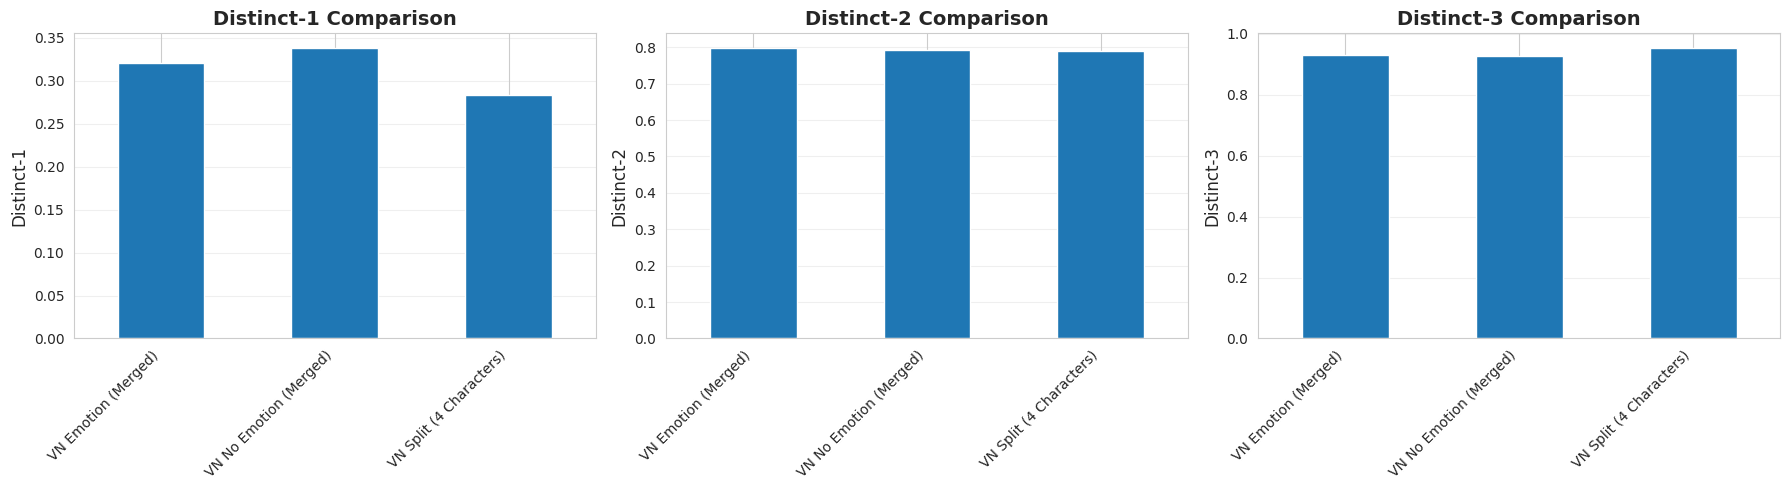

✓ Saved diversity comparison plot


In [17]:
# Bar chart: Diversity metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Distinct-1', 'Distinct-2', 'Distinct-3']
for i, metric in enumerate(metrics):
    ax = axes[i]
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xlabel('')
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'diversity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved diversity comparison plot")

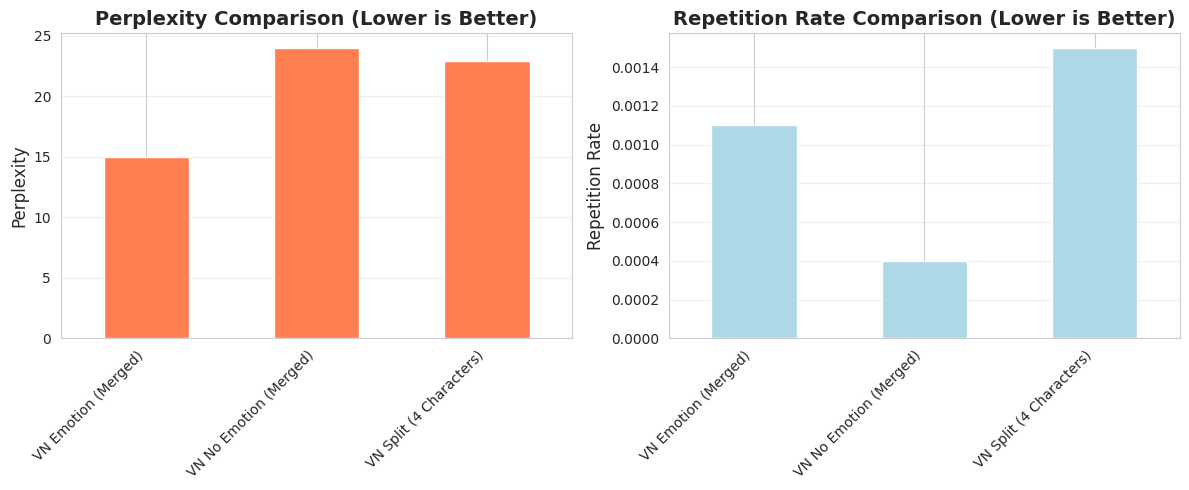

✓ Saved quality comparison plot


In [18]:
# Bar chart: Perplexity and Repetition
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Perplexity
comparison_df.plot(x='Model', y='Perplexity', kind='bar', ax=axes[0], legend=False, color='coral')
axes[0].set_title('Perplexity Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Perplexity', fontsize=12)
axes[0].set_xlabel('')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Repetition
comparison_df.plot(x='Model', y='Repetition', kind='bar', ax=axes[1], legend=False, color='lightblue')
axes[1].set_title('Repetition Rate Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Repetition Rate', fontsize=12)
axes[1].set_xlabel('')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'quality_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved quality comparison plot")

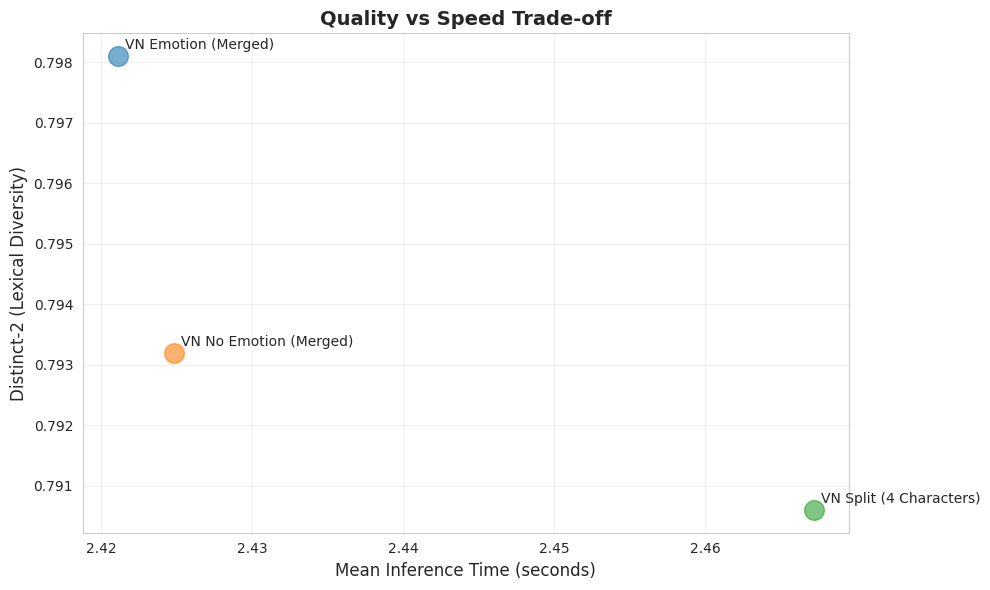

✓ Saved quality vs speed plot


In [19]:
# Scatter plot: Quality vs Speed trade-off
fig, ax = plt.subplots(figsize=(10, 6))

for idx, row in comparison_df.iterrows():
    ax.scatter(row['Inference Time (s)'], row['Distinct-2'], s=200, alpha=0.6)
    ax.annotate(row['Model'], (row['Inference Time (s)'], row['Distinct-2']), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)

ax.set_xlabel('Mean Inference Time (seconds)', fontsize=12)
ax.set_ylabel('Distinct-2 (Lexical Diversity)', fontsize=12)
ax.set_title('Quality vs Speed Trade-off', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'quality_vs_speed.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved quality vs speed plot")

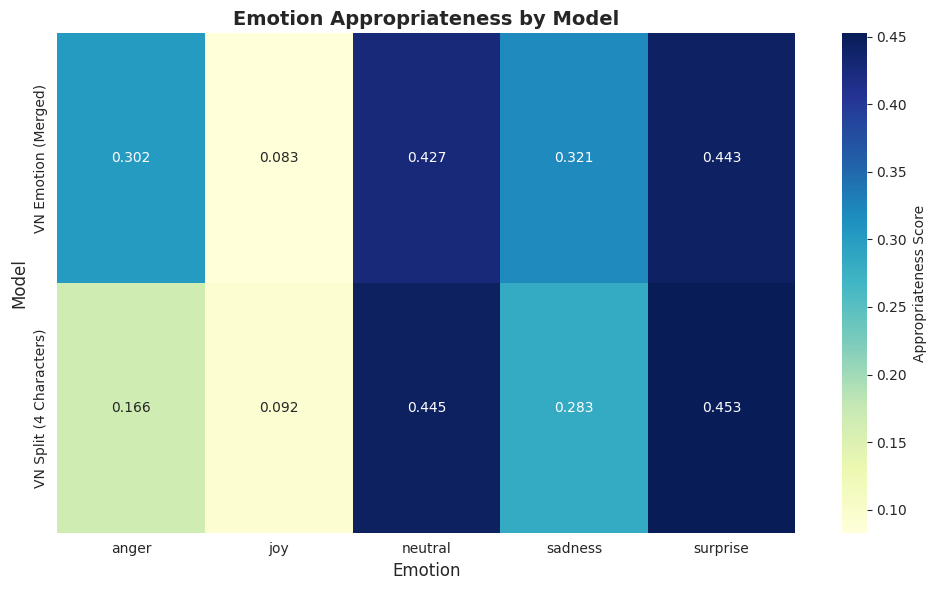

✓ Saved emotion appropriateness heatmap


In [20]:
# Per-emotion heatmap (if emotion models exist)
if emotion_models and not emotion_df.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare data for heatmap
    heatmap_data = emotion_df.set_index('Emotion')
    
    # Create heatmap
    sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='YlGnBu', 
                cbar_kws={'label': 'Appropriateness Score'}, ax=ax)
    ax.set_title('Emotion Appropriateness by Model', fontsize=14, fontweight='bold')
    ax.set_xlabel('Emotion', fontsize=12)
    ax.set_ylabel('Model', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'emotion_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved emotion appropriateness heatmap")

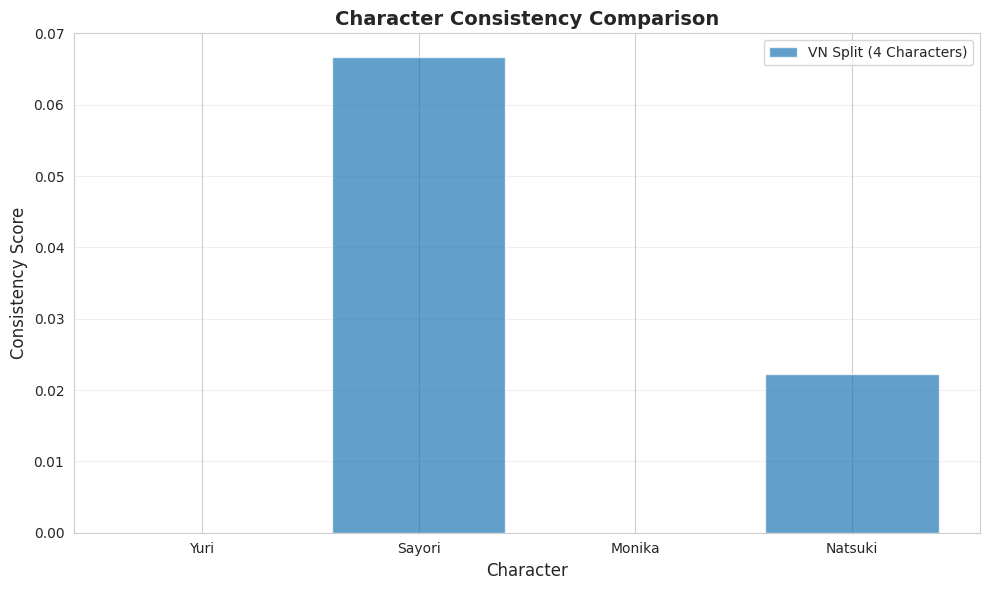

✓ Saved character consistency plot


In [21]:
# Character consistency comparison (if split model exists)
if split_models:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for model_id, results in split_models.items():
        characters = []
        consistencies = []
        for character, metrics in results['character_metrics']['per_character'].items():
            characters.append(character)
            consistencies.append(metrics['consistency'])
        
        x_pos = np.arange(len(characters))
        ax.bar(x_pos, consistencies, alpha=0.7, label=results['model_name'])
    
    ax.set_xlabel('Character', fontsize=12)
    ax.set_ylabel('Consistency Score', fontsize=12)
    ax.set_title('Character Consistency Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(characters)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'character_consistency.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved character consistency plot")

### Sample Generation Comparison

In [22]:
# Load generations for side-by-side comparison
all_generations = {}

for model_id in MODEL_CONFIGS.keys():
    gen_path = RESULTS_DIR / f"{model_id}_generations.json"
    if gen_path.exists():
        with open(gen_path, 'r', encoding='utf-8') as f:
            all_generations[model_id] = json.load(f)

print(f"✓ Loaded generations for {len(all_generations)} models")

✓ Loaded generations for 3 models


In [23]:
# Show side-by-side comparison for selected prompts
sample_indices = [0, 15, 30, 45, 60]  # Select diverse samples

print("="*80)
print("SAMPLE GENERATION COMPARISON")
print("="*80)

for idx in sample_indices:
    if idx >= len(TEST_PROMPTS):
        continue
    
    prompt = TEST_PROMPTS[idx]
    
    print(f"\n{'─'*80}")
    print(f"Prompt #{idx + 1}:")
    print(f"  Character: {prompt['character']}")
    print(f"  Emotion: {prompt['emotion']}")
    print(f"  Affection: {prompt['affection']}/100")
    print(f"  Scenario: {prompt['scenario']}")
    print(f"  User Input: \"{prompt['user_input']}\"")
    print(f"{'─'*80}")
    
    for model_id, generations in all_generations.items():
        if idx < len(generations):
            gen = generations[idx]
            model_name = all_results[model_id]['model_name']
            print(f"\n{model_name}:")
            print(f"  Response: \"{gen['response']}\"")
            print(f"  Inference Time: {gen['inference_time']:.3f}s")
            print(f"  Tokens: {gen['num_tokens']}")

print("\n" + "="*80)

SAMPLE GENERATION COMPARISON

────────────────────────────────────────────────────────────────────────────────
Prompt #1:
  Character: Monika
  Emotion: joy
  Affection: 40/100
  Scenario: greeting
  User Input: "Hi Monika! How are you doing today?"
────────────────────────────────────────────────────────────────────────────────

VN Emotion (Merged):
  Response: "I'm doing wonderfully, thank you for asking. The sun seems to be shining brighter when I'm surrounded by people who appreciate true literature and meaningful connections. It's lovely to see someone as vibrant and full of life as yourself on this beautiful day."
  Inference Time: 2.875s
  Tokens: 50

VN No Emotion (Merged):
  Response: "You can be direct when you want to connect, or philosophical when the mood strikes. Your nature is warm and genuine, suited to both intimate moments and deep conversations. You're doing well today, I sense that you value meaningful connections and enjoy nuanced discussions"
  Inference Time: 2.4

---
## 5. Summary & Recommendations 📝

In [24]:
# Find best model for each metric
print("="*80)
print("BEST MODEL BY METRIC")
print("="*80)

metrics_to_check = [
    ('Distinct-2', 'max', 'Lexical Diversity'),
    ('Perplexity', 'min', 'Model Confidence'),
    ('Repetition', 'min', 'Repetition Avoidance'),
    ('Inference Time (s)', 'min', 'Inference Speed'),
]

if 'Emotion Appropriateness' in comparison_df.columns:
    metrics_to_check.append(('Emotion Appropriateness', 'max', 'Emotion Awareness'))

if 'Character Consistency' in comparison_df.columns:
    metrics_to_check.append(('Character Consistency', 'max', 'Character Consistency'))

best_models = {}
for metric, direction, label in metrics_to_check:
    if metric in comparison_df.columns:
        if direction == 'max':
            best_idx = comparison_df[metric].idxmax()
        else:
            best_idx = comparison_df[metric].idxmin()
        
        best_model = comparison_df.loc[best_idx, 'Model']
        best_value = comparison_df.loc[best_idx, metric]
        best_models[label] = (best_model, best_value)
        
        print(f"\n{label}:")
        print(f"  🏆 {best_model}: {best_value:.4f}")

print("\n" + "="*80)

BEST MODEL BY METRIC

Lexical Diversity:
  🏆 VN Emotion (Merged): 0.7981

Model Confidence:
  🏆 VN Emotion (Merged): 14.9859

Repetition Avoidance:
  🏆 VN No Emotion (Merged): 0.0004

Inference Speed:
  🏆 VN Emotion (Merged): 2.4211

Emotion Awareness:
  🏆 VN Split (4 Characters): 0.2835

Character Consistency:
  🏆 VN Split (4 Characters): 0.0229



In [25]:
# Overall recommendations
print("="*80)
print("RECOMMENDATIONS")
print("="*80)

print("\n📌 BEST FOR QUALITY:")
quality_score = comparison_df['Distinct-2'] - comparison_df['Repetition']
best_quality_idx = quality_score.idxmax()
best_quality = comparison_df.loc[best_quality_idx, 'Model']
print(f"   {best_quality}")
print(f"   - Highest lexical diversity")
print(f"   - Lowest repetition")

print("\n⚡ BEST FOR SPEED:")
best_speed_idx = comparison_df['Inference Time (s)'].idxmin()
best_speed = comparison_df.loc[best_speed_idx, 'Model']
print(f"   {best_speed}")
print(f"   - Fastest inference time")

if 'Emotion Appropriateness' in comparison_df.columns:
    print("\n❤️ BEST FOR EMOTION-AWARE RESPONSES:")
    best_emotion_idx = comparison_df['Emotion Appropriateness'].idxmax()
    best_emotion = comparison_df.loc[best_emotion_idx, 'Model']
    print(f"   {best_emotion}")
    print(f"   - Highest emotion appropriateness score")

if 'Character Consistency' in comparison_df.columns:
    print("\n🎭 BEST FOR CHARACTER CONSISTENCY:")
    best_char_idx = comparison_df['Character Consistency'].idxmax()
    best_char = comparison_df.loc[best_char_idx, 'Model']
    print(f"   {best_char}")
    print(f"   - Highest character consistency")
    print(f"   - Lowest name bleeding")

print("\n⚖️ BEST BALANCE:")
# Normalize all metrics to 0-1 scale
normalized = comparison_df.copy()
for col in ['Distinct-2', 'Inference Time (s)', 'Repetition', 'Perplexity']:
    if col in normalized.columns:
        if col in ['Inference Time (s)', 'Repetition', 'Perplexity']:
            # Lower is better - invert
            normalized[col] = 1 - (normalized[col] - normalized[col].min()) / (normalized[col].max() - normalized[col].min())
        else:
            # Higher is better
            normalized[col] = (normalized[col] - normalized[col].min()) / (normalized[col].max() - normalized[col].min())

# Calculate overall score
score_cols = ['Distinct-2', 'Inference Time (s)', 'Repetition', 'Perplexity']
normalized['overall_score'] = normalized[score_cols].mean(axis=1)
best_balance_idx = normalized['overall_score'].idxmax()
best_balance = comparison_df.loc[best_balance_idx, 'Model']
print(f"   {best_balance}")
print(f"   - Best combination of quality, speed, and consistency")

print("\n" + "="*80)

RECOMMENDATIONS

📌 BEST FOR QUALITY:
   VN Emotion (Merged)
   - Highest lexical diversity
   - Lowest repetition

⚡ BEST FOR SPEED:
   VN Emotion (Merged)
   - Fastest inference time

❤️ BEST FOR EMOTION-AWARE RESPONSES:
   VN Split (4 Characters)
   - Highest emotion appropriateness score

🎭 BEST FOR CHARACTER CONSISTENCY:
   VN Split (4 Characters)
   - Highest character consistency
   - Lowest name bleeding

⚖️ BEST BALANCE:
   VN Emotion (Merged)
   - Best combination of quality, speed, and consistency



---
## 6. Export Results 💾

In [26]:
# Save comparison summary as JSON
summary_json_path = RESULTS_DIR / 'comparison_summary.json'

summary = {
    'evaluation_date': datetime.now().isoformat(),
    'num_models': len(all_results),
    'num_test_prompts': len(TEST_PROMPTS),
    'models_evaluated': [config['name'] for config in MODEL_CONFIGS.values()],
    'overall_comparison': comparison_df.to_dict(orient='records'),
    'best_models': best_models,
}

if emotion_models:
    summary['per_emotion_comparison'] = emotion_df.to_dict(orient='records')

with open(summary_json_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print(f"✓ Saved comparison summary to {summary_json_path}")

✓ Saved comparison summary to ../results/vn_comparison/comparison_summary.json


In [27]:
# Save comparison summary as CSV
summary_csv_path = RESULTS_DIR / 'comparison_summary.csv'
comparison_df.to_csv(summary_csv_path, index=False)

print(f"✓ Saved comparison summary to {summary_csv_path}")

✓ Saved comparison summary to ../results/vn_comparison/comparison_summary.csv


In [28]:
# Append to evaluation history
history_path = Path('../results/evaluation_history.csv')

for model_id, results in all_results.items():
    ref_free = results['reference_free_metrics']
    perf = results['performance_metrics']
    
    history_entry = {
        'timestamp': results['evaluation_timestamp'],
        'model_name': results['model_name'],
        'model_type': results['model_type'],
        'has_emotion': results['has_emotion'],
        'num_samples': results['num_test_prompts'],
        'distinct_1': ref_free['distinct_1'],
        'distinct_2': ref_free['distinct_2'],
        'distinct_3': ref_free['distinct_3'],
        'mean_repetition': ref_free['mean_repetition'],
        'mean_length': ref_free['mean_length'],
        'mean_perplexity': ref_free['mean_perplexity'],
        'mean_inference_time': perf['mean_inference_time'],
    }
    
    # Add emotion metrics if available
    if results['emotion_metrics']:
        history_entry['emotion_appropriateness'] = results['emotion_metrics']['overall_appropriateness']
    
    # Append to history
    history_df = pd.DataFrame([history_entry])
    
    if history_path.exists():
        history_df.to_csv(history_path, mode='a', header=False, index=False)
    else:
        history_df.to_csv(history_path, mode='w', header=True, index=False)

print(f"✓ Appended results to evaluation history: {history_path}")

✓ Appended results to evaluation history: ../results/evaluation_history.csv


---
## 🎉 Evaluation Complete!

### Results saved to:
- `results/vn_comparison/test_prompts.json` - Test dataset
- `results/vn_comparison/{model}_generations.json` - Generated responses per model
- `results/vn_comparison/{model}_metrics.json` - Computed metrics per model
- `results/vn_comparison/comparison_summary.json` - Final comparison
- `results/vn_comparison/comparison_summary.csv` - Final comparison (CSV)
- `results/vn_comparison/*.png` - Visualization plots
- `results/evaluation_history.csv` - Historical tracking

### Next Steps:
1. Review the comparison tables and visualizations above
2. Check sample generations for qualitative assessment
3. Use the recommendations to select the best model for your use case
4. Re-run with `force_rerun=True` to update results after retraining